# MSM vs PGABM - BC Model observed positive
In this notebook we compare the performances of MSM and PGABM for a BC model with observed positive interactions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path += ["../src"]
import simulator_BC as sim_bc
import simulator_BC_evidences as sim_bc_e
import estimation_epsilon_BC as est_bc
import jax_estimation_BC as jest_bc
#import positive_edges_BC_estimation as pos_est
import calibration_observed_positive_BC as pos_cal
from calibrator_blackit import Calibrator #i just commented few lines of code to remove the output print
#from black_it.calibrator import Calibrator
import pandas as pd
from black_it.samplers.halton import HaltonSampler
import os
import contextlib
from scipy.special import expit as sigmoid
import torch
from itertools import product
import importlib
from time import time
import jax.numpy as jnp
import positive_edges_estimation_BC as pos_est

In [68]:
N = 200
T, edge_per_t = 200, 4
rho = 70
mu = 0.2
epsilon = 0.0011

In [69]:
X, edges = sim_bc_e.simulator_BC_evidence(N,T,edge_per_t,epsilon,mu)
X, edges = sim_bc.simulator_stoch(N,T,edge_per_t,epsilon,mu, steepness = 70)

### MSM

In [70]:
simulator_BC_pos = pos_cal.BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)

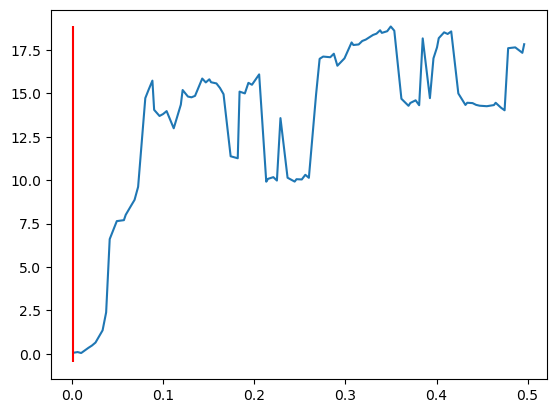

In [71]:
calibrate_epsilon = pos_cal.calibrate_epsilon_BC(simulator_BC_pos, plot_loss = True, calibration_batches = 100, 
                                                 sampler = HaltonSampler, batch_size = 1,
                                                 precisions = [0.0001], return_time = True)

In [72]:
epsilon_BCcal, loss_BCcal, time = calibrate_epsilon["epsilon"], calibrate_epsilon["loss"], calibrate_epsilon["time"]
#loss_epsilon_df = pd.DataFrame([{"epsilon": epsilon_BCcal[k,0], "loss": loss_BCcal[k]} for k in range(len(loss_BCcal))]).sort_values("epsilon").set_index("epsilon")

In [73]:
epsilon, epsilon_BCcal, time

(0.0011, 0.0098, 5.232925891876221)

### PGABMs

In [80]:
history_torch = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.01, rho = 70,
                                                 num_epochs = 500, optimizer_name = "adam", 
                                                 lr = 0.01, hide_progress = False, sample_pairs = 100,
                                                 min_delta = 1e-6, patience = 15, return_time = True, min_epochs = 20)

100%|████████████████████████████████████████| 500/500 [00:01<00:00, 391.16it/s]


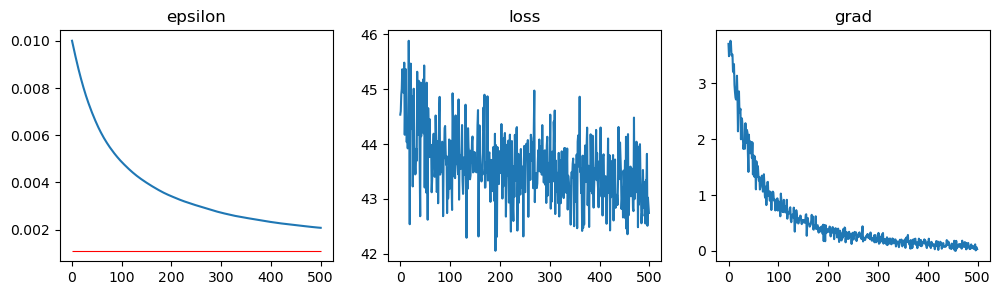

In [81]:
est_bc.print_history(history_torch, epsilon = epsilon)

In [82]:
epsilon, history_torch["epsilon"][-1], history_torch["time"]

(0.0011, 0.0020733965653997825, 1.283400058746338)

In [83]:
def compare_msm_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0, calibration_batches):
    X, edges = sim_bc.simulator_stoch(N, T, edge_per_t, epsilon, mu, rho)
    
    simulator_BC_pos = pos_cal.BC_observe_positive_simulator_given_previous_time(X, edges, mu, epsilon)
    calibration = pos_cal.calibrate_epsilon_BC(simulator_BC_pos, plot_loss = False, calibration_batches = calibration_batches, 
                                                 sampler = HaltonSampler,
                                                 precisions = [0.0001], return_time = True)
    epsilon_BCcal, loss_BCcal, time = calibrate_epsilon["epsilon"], calibrate_epsilon["loss"], calibrate_epsilon["time"] #BC_cal.calibrate(calibration_batches)

                
    estimation_pgabm = pos_est.estimation_epsilon_torch(X, edges, mu, epsilon0 = 0.25, rho = 70,
                                                 num_epochs = 500, optimizer_name = "adam", 
                                                 lr = 0.01, hide_progress = True, sample_pairs = 50,
                                                 min_delta = 1e-5, patience = 5, return_time = True, min_epochs = 20)
    
    return {"N": N, "T": T, "edge_per_t": edge_per_t, "tot_edges": T * edge_per_t,
            "epsilon": epsilon, "epsilon0": epsilon0, "mu": mu,
            "epsilon_pgabm": estimation_pgabm["epsilon"][-1], "time_pgabm": estimation_pgabm["time"],
            "epsilon_msm": calibration["epsilon"], "time_msm": calibration["time"], "calibration_batches": calibration_batches
           }

def repeat_comparison_msm_pgabm(N_list, T_list, edge_per_t_list, calibration_batches_list,
                                        repetitions = 1):
    
    simulations_comparison = []
    
    tot_sim = len(N_list) * len(T_list) * len(edge_per_t_list) * len(calibration_batches_list) * repetitions
    
    print("Total simulations", tot_sim)
    epsilons = np.random.random(size = tot_sim) / 2
    mus = np.random.random(size = tot_sim) 
    epsilon0 = 0.25
    
    sim = 0
    for _, edge_per_t, N, T, calibration_batches in (product(np.arange(repetitions),
                                                             edge_per_t_list,
                                                             N_list, T_list, calibration_batches_list)):
        epsilon = epsilons[sim]
        mu = mus[sim] * min(1, 2000 / (T * edge_per_t))
        
        sim += 1
        print("Simulation", sim)
        
        comparison = compare_msm_pgabm(N, T, edge_per_t, mu, epsilon, epsilon0, calibration_batches)
        
        simulations_comparison.append(comparison)
            
    return pd.DataFrame(simulations_comparison).assign(distance_pgabm = lambda x: np.abs(x["epsilon_pgabm"] - x["epsilon"]),
                                                       distance_msm = lambda x: np.abs(x["epsilon_msm"] - x["epsilon"])
                                                      )

In [ ]:
repeated_comparisons = repeat_comparison_msm_pgabm(N_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                           T_list = [int(u) for u in np.logspace(2, 4, num = 4)], 
                                                           edge_per_t_list = [1,2,4],
                                                           calibration_batches_list = [20,50,100], 
                                                   repetitions = 5)

In [ ]:
repeated_comparisons.to_csv("../data/comparison_calibration_pgabm_positiveBC_230518.csv", index = 0)

repeated_comparisons = pd.read_csv("../data/comparison_calibration_pgabm_positiveBC_230518.csv")

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = [6, 3])

sns.violinplot(data = repeated_comparisons, y = "distance_pgabm", ax = axes[0])
sns.violinplot(data = repeated_comparisons, y = "time_pgabm", ax = axes[1])

In [24]:
repeated_comparisons.sort_values("distance_pgabm", ascending = False).head(30)

,N,T,edge_per_t,tot_edges,epsilon,epsilon0,mu,epsilon_pgabm,time_pgabm,epsilon_msm,time_msm,calibration_batches,distance_pgabm,distance_msm
38,10000,100,1,100,0.006976,0.25,0.708461,0.250000,0.018281,0.0013,1.241176,100,0.243024,0.005676
581,100,464,1,464,0.003966,0.25,0.034431,0.090919,0.211272,0.0159,2.592970,100,0.086952,0.011934
78,2154,2154,2,4308,0.007767,0.25,0.302595,0.089824,1.368834,0.0329,4.109501,20,0.082058,0.025133
329,10000,464,1,464,0.004674,0.25,0.991945,0.085275,0.336747,0.0104,2.536776,100,0.080601,0.005726
532,100,464,4,1856,0.001556,0.25,0.526852,0.081255,0.259386,0.0073,2.905744,50,0.079698,0.005744
285,10000,10000,4,40000,0.001509,0.25,0.018670,0.079392,4.435303,0.0266,103.785151,20,0.077883,0.025091
268,2154,464,4,1856,0.013892,0.25,0.681645,0.091403,0.255525,0.0117,2.839351,50,0.077511,0.002192
519,10000,464,2,928,0.001897,0.25,0.523555,0.079129,0.302811,0.0263,0.693530,20,0.077233,0.024403
88,10000,464,2,928,0.026955,0.25,0.474006,0.103930,0.310486,0.0208,1.788798,50,0.076976,0.006155
92,10000,2154,2,4308,0.000201,0.25,0.250533,0.075909,1.453095,0.0076,20.694692,100,0.075708,0.007399


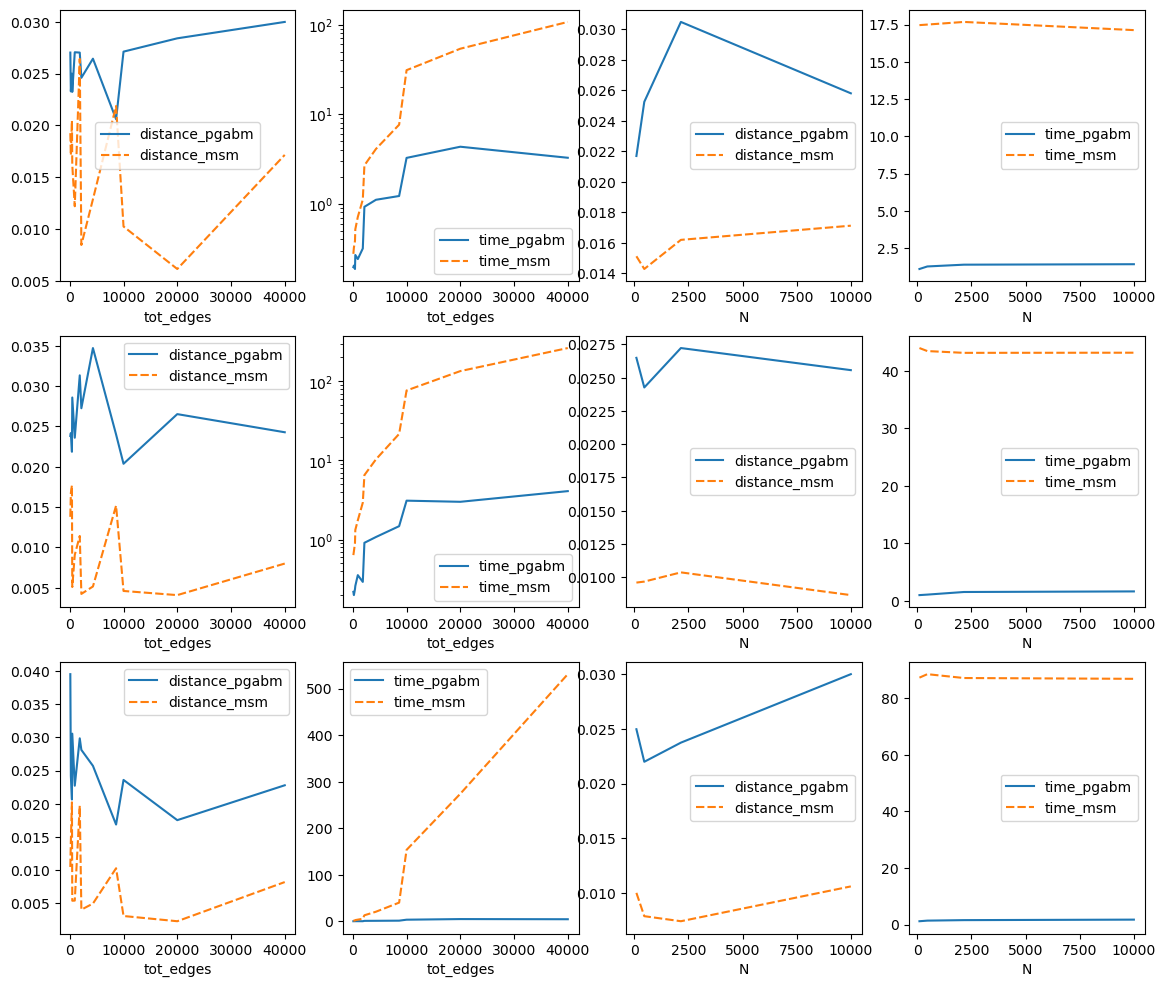

In [23]:
fig, axes = plt.subplots(ncols = 4, nrows = 3, figsize = [14,12])

sns.lineplot(data = repeated_comparisons.query("calibration_batches == 20").groupby("tot_edges").mean()[["distance_pgabm", "distance_msm"]], ax = axes[0,0])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 20").groupby("tot_edges").mean()[["time_pgabm", "time_msm"]], ax = axes[0,1])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 20").groupby("N").mean()[["distance_pgabm", "distance_msm"]], ax = axes[0,2])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 20").groupby("N").mean()[["time_pgabm", "time_msm"]], ax = axes[0,3])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 50").groupby("tot_edges").mean()[["distance_pgabm", "distance_msm"]], ax = axes[1,0])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 50").groupby("tot_edges").mean()[["time_pgabm", "time_msm"]], ax = axes[1,1])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 50").groupby("N").mean()[["distance_pgabm", "distance_msm"]], ax = axes[1,2])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 50").groupby("N").mean()[["time_pgabm", "time_msm"]], ax = axes[1,3])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 100").groupby("tot_edges").mean()[["distance_pgabm", "distance_msm"]], ax = axes[2,0])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 100").groupby("tot_edges").mean()[["time_pgabm", "time_msm"]], ax = axes[2,1])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 100").groupby("N").mean()[["distance_pgabm", "distance_msm"]], ax = axes[2,2])
sns.lineplot(data = repeated_comparisons.query("calibration_batches == 100").groupby("N").mean()[["time_pgabm", "time_msm"]], ax = axes[2,3])
axes[0,1].set_yscale("log")
axes[1,1].set_yscale("log")


<AxesSubplot:xlabel='calibration_batches', ylabel='time_msm'>

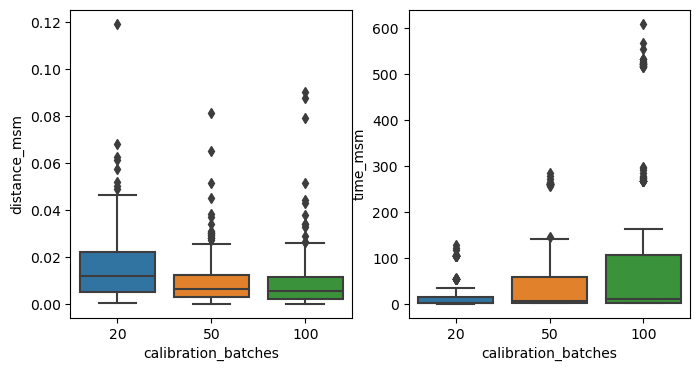

In [204]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = [8,4])

sns.boxplot(data = repeated_comparisons, x = "calibration_batches", y = "distance_msm", ax = axes[0])
sns.boxplot(data = repeated_comparisons, x = "calibration_batches", y = "time_msm", ax = axes[1])


